In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

from torch.utils.data import DataLoader, TensorDataset

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [2]:
df = pd.read_csv(fr'C:\Users\ivane\Desktop\Dissertation\data\merged_data.csv')
df.head()

,Date,Open,Close,Change,sentiment,sentiment_score
0,2025-01-10,3761.549,3736.886,-0.66,0,0.700804
1,2024-12-19,3780.106,3708.531,-1.93,0,0.950467
2,2024-12-18,3774.744,3781.551,0.18,1,0.460880
3,2024-12-16,3748.220,3765.163,0.45,1,0.771217
4,2024-12-12,3744.519,3748.267,0.10,1,0.927686


In [3]:

# Convert 'Date' column to datetime objects if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Select features and target variable
features = ['Open', 'sentiment_score'] # Add more relevant features
target = 'Close'

# Scale the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])

In [4]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, -1]  # Target is the last column (Close price)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


seq_length = 10 # Adjust the sequence length as needed
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer with one neuron for regression

model.compile(optimizer='adam', loss='mean_squared_error')

In [5]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32) #Adjust epochs and batch size


# Evaluate the model on test data
loss = model.evaluate(X_test, y_test)


Epoch 1/50
11/11 [==============================] - 3s 7ms/step - loss: 0.0980
Epoch 2/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0241
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0172
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0126
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0101
Epoch 6/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0094
Epoch 7/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0093
Epoch 8/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 9/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 10/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 11/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 12/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0086
Epoch 13/50
11/11 [==============================

3/3 [==============================] - 1s 4ms/step
Test Loss (MSE): 0.0051467763260006905
Mean Absolute Error (MAE): 24.281109486273824
R-squared (R2): 0.8262852216633121


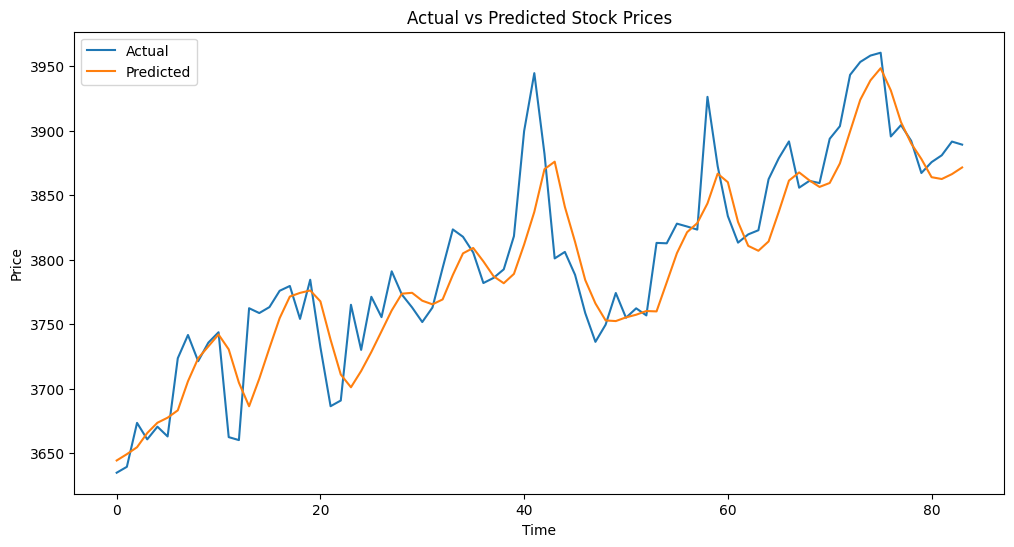

In [6]:
import matplotlib.pyplot as plt

# Predict on the test data
y_pred = model.predict(X_test)

# Inverse transform the scaled data to get actual prices
y_test_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_pred.reshape(-1, 1)), axis=1))[:, -1]

mae = mean_absolute_error(y_test_actual, y_pred_actual)

# Calculate R-squared (R2)
r2 = r2_score(y_test_actual, y_pred_actual)

# Print the results
print(f"Test Loss (MSE): {loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plot the actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_actual, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

In [7]:
# Assuming 'df' is your DataFrame
# Select relevant columns and convert the 'Date' column to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])
data = df[['Date', 'Close']]
data = data.set_index('Date')

# Normalize the data
scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Prepare the data for the CNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10 # Example sequence length
X, y = create_sequences(data['Close'].values, seq_length)

# Reshape data for CNN input
X = X.reshape(X.shape[0], X.shape[1], 1)


# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model 
model.fit(X, y, epochs=100, batch_size=32, verbose=10) # Adjust epochs and batch size as needed


Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

14/14 [==============================] - 0s 1ms/step - loss: 0.0043
Test Loss: 0.00431275786831975
Mean Absolute Error (MAE): 21.85929888872314
R-squared (R2): 0.8972190791839845


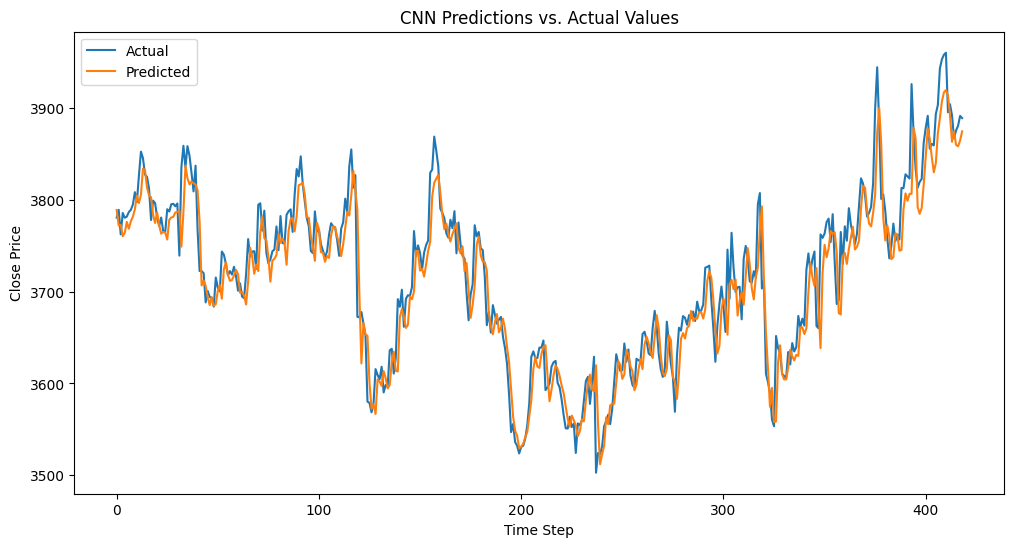

In [8]:
predictions = model.predict(X)

# Inverse transform the predictions and actual values to get original scale
predictions = scaler.inverse_transform(predictions)
y_original = scaler.inverse_transform(y.reshape(-1, 1))

# print loss
loss = model.evaluate(X, y)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_original, predictions)

# Calculate the R-squared (R2)
r2 = r2_score(y_original, predictions)

# Print the results
print(f"Test Loss: {loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")


# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(y_original, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('CNN Predictions vs. Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.show()

# CNN-LSTM

Epoch 1/200
11/11 [==============================] - 4s 5ms/step - loss: 0.1045
Epoch 2/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0290
Epoch 3/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0200
Epoch 4/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0140
Epoch 5/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0113
Epoch 6/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 7/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0104
Epoch 8/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0104
Epoch 9/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0098
Epoch 10/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0101
Epoch 11/200
11/11 [==============================] - 0s 8ms/step - loss: 0.0103
Epoch 12/200
11/11 [==============================] - 0s 8ms/step - loss: 0.0095
Epoch 13/200
11/11 [=================

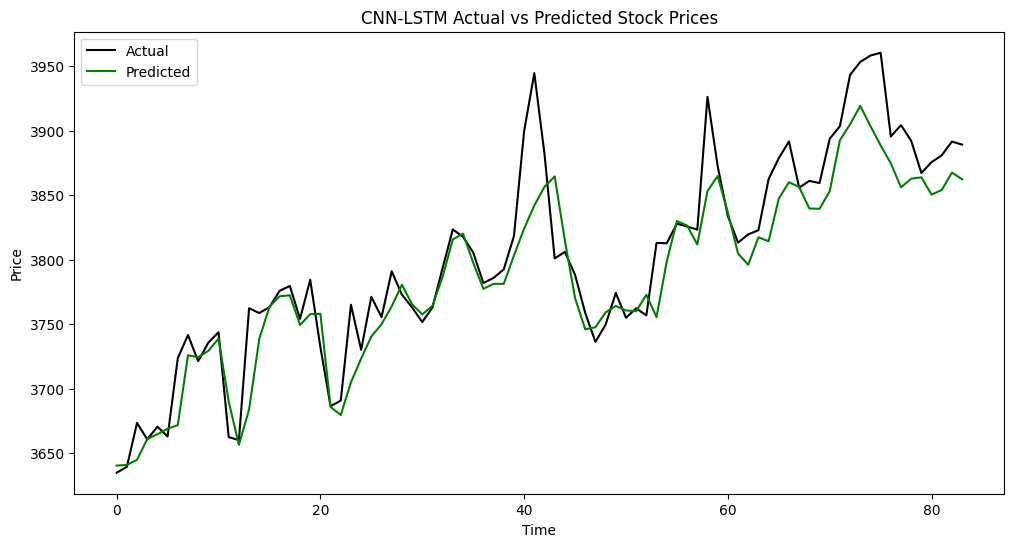

In [9]:
# Reshape data for CNN-LSTM input
X_train_cnn_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_cnn_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Build the CNN-LSTM model
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, X_train.shape[2])))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(LSTM(units=50, return_sequences=True))
cnn_lstm_model.add(LSTM(units=50))
cnn_lstm_model.add(Dense(units=1))

# Compile the model
cnn_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
cnn_lstm_model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1)

# Evaluate the model on test data
cnn_lstm_loss = cnn_lstm_model.evaluate(X_test, y_test)

# Predict on the test data
cnn_lstm_y_pred = cnn_lstm_model.predict(X_test)

# Inverse transform the scaled data to get actual prices
cnn_lstm_y_test_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]
cnn_lstm_y_pred_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], cnn_lstm_y_pred.reshape(-1, 1)), axis=1))[:, -1]

cnn_lstm_mae = mean_absolute_error(cnn_lstm_y_test_actual, cnn_lstm_y_pred_actual)

# Calculate R-squared (R2)
cnn_lstm_r2 = r2_score(cnn_lstm_y_test_actual, cnn_lstm_y_pred_actual)

# Print the results
print(f"Test Loss (MSE): {cnn_lstm_loss}")
print(f"Mean Absolute Error (MAE): {cnn_lstm_mae}")
print(f"R-squared (R2): {cnn_lstm_r2}")

# Plot the actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(cnn_lstm_y_test_actual, label='Actual', color='black')
plt.plot(cnn_lstm_y_pred_actual, label='Predicted', color='green')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('CNN-LSTM Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

# CNN-LSTM 2

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch
from sklearn.preprocessing import MinMaxScaler

np_arr= np.array(df['Close'])
mean= np_arr.mean()
std= np_arr.std()
np_arr= (np_arr-mean)/std

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.CNNModel= nn.Sequential(
        nn.Conv1d(in_channels=5, out_channels=32, kernel_size=1, padding="same"),
        nn.Tanh(),
        nn.MaxPool1d(kernel_size=1, padding=0),
        nn.ReLU()
    )
    self.LSTMModel= nn.Sequential(
        nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
    )
    self.LinearModel= nn.Sequential(
        nn.Tanh(),
        nn.Linear(in_features=64, out_features=1)
    )

  def forward(self, data):
    out1= self.CNNModel(data)
    out2, _= self.LSTMModel(data)
    out3= self.LinearModel(out2[:, -1, :])
    out4= torch.reshape(out3, (len(out2), ))
    return out4

from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        self.length = len(X_data)

    def __getitem__(self, index):
        x = self.X_data[index]
        y = self.y_data[index]
        return x, y

    def __len__(self):
        return self.length

def create_windows(arr, window):
  X,y=[],[]
  for i in range(window, len(arr)):
    X.append(arr[i-window:i])
    y.append(arr[i])
  return torch.reshape((torch.tensor(X)).to(torch.float32), (len(X), window, 1)), (torch.tensor(y)).to(torch.float32)

device = "cuda:0" if torch.cuda.is_available() else "cpu" # training on GPU for convenience
print(device)
train_size = int(len(np_arr) * 0.8)


cpu


In [25]:
# This value determines how many past days will be considered for the price prediction, and the value is same as the
# number of features parameter mentioned in paper
lookback = 5
X_train, y_train = create_windows(np_arr[:train_size], lookback)
X_test, y_test = create_windows(np_arr[train_size:], lookback)

train_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_test, y_test)
batch_size = 32
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

num_epoch = 200
model = Model()
model = model.to(device)
optim = torch.optim.Adam(model.parameters())
loss = torch.nn.L1Loss()

for epoch in range(num_epoch):
    model.train()
    train_loss = 0
    for i, (X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        lossv = loss(y_pred, y)
        train_loss += lossv

        optim.zero_grad()
        lossv.backward()
        optim.step()

    train_loss /= len(train_loader)

    model.eval()
    test_loss = 0
    with torch.inference_mode():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            lossw = loss(y_pred, y)
            test_loss += lossw

        test_loss /= len(test_loader)

    print(f"Epoch: {epoch+1}/{num_epoch}, Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

# Plotting for each combination of lookback and number of epochs

Epoch: 1/200, Train Loss: 0.7911, Test Loss: 1.0400
Epoch: 2/200, Train Loss: 0.7299, Test Loss: 0.9756
Epoch: 3/200, Train Loss: 0.6661, Test Loss: 0.8990
Epoch: 4/200, Train Loss: 0.5729, Test Loss: 0.7885
Epoch: 5/200, Train Loss: 0.4257, Test Loss: 0.6496
Epoch: 6/200, Train Loss: 0.3497, Test Loss: 0.5208
Epoch: 7/200, Train Loss: 0.3282, Test Loss: 0.4739
Epoch: 8/200, Train Loss: 0.3245, Test Loss: 0.4971
Epoch: 9/200, Train Loss: 0.3163, Test Loss: 0.5207
Epoch: 10/200, Train Loss: 0.3145, Test Loss: 0.5086
Epoch: 11/200, Train Loss: 0.3122, Test Loss: 0.4973
Epoch: 12/200, Train Loss: 0.3086, Test Loss: 0.4830
Epoch: 13/200, Train Loss: 0.3046, Test Loss: 0.4702
Epoch: 14/200, Train Loss: 0.3010, Test Loss: 0.4561
Epoch: 15/200, Train Loss: 0.2971, Test Loss: 0.4456
Epoch: 16/200, Train Loss: 0.2929, Test Loss: 0.4332
Epoch: 17/200, Train Loss: 0.2893, Test Loss: 0.4120
Epoch: 18/200, Train Loss: 0.2832, Test Loss: 0.4031
Epoch: 19/200, Train Loss: 0.2787, Test Loss: 0.3805
Ep

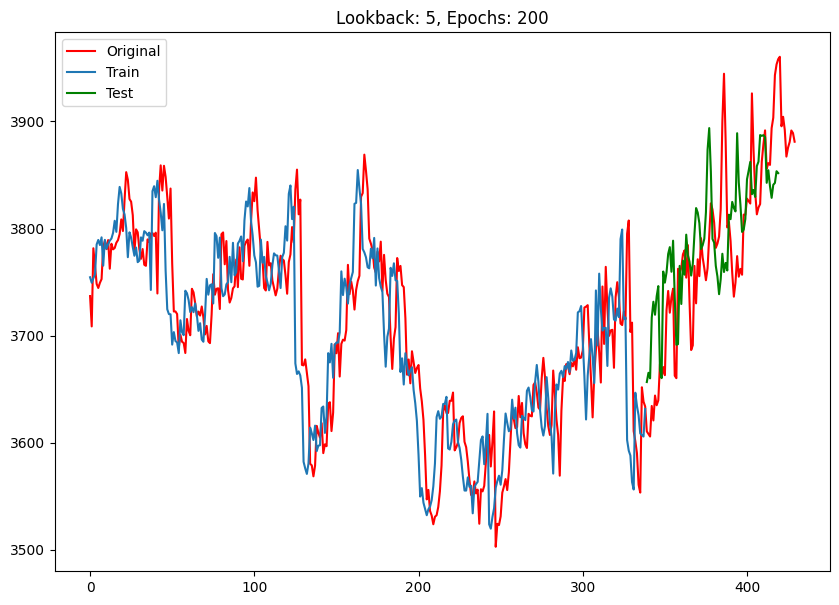

In [26]:
model.eval()
with torch.no_grad():
    train_outputs = []
    for X, _ in train_loader:
        X = X.to(device)
        y_pred = model(X)
        train_outputs.append(y_pred.cpu().numpy())

    train_outputs = np.concatenate(train_outputs)

test_outputs = []
with torch.no_grad():
    for X, _ in test_loader:
        X = X.to(device)
        y_pred = model(X)
        test_outputs.append(y_pred.cpu().numpy())

test_outputs = np.concatenate(test_outputs)

#multiplying back the mean and standard deviation, essentially undoing the normalization before plotting
plt.figure(figsize=(10, 7))
plt.plot(range(len(np_arr)), np_arr*std+mean, label="Original", c="r")
plt.plot(range(len(train_outputs)), train_outputs*std+mean, label="Train")
plt.plot(range(len(train_outputs), len(train_outputs) + len(test_outputs)), test_outputs*std+mean, label="Test", c="g")
plt.title(f"Lookback: {lookback}, Epochs: {num_epoch}")
plt.legend()
plt.show()

In [27]:
y_test2= y_test*std+mean
test_outputs2= test_outputs*std+mean

from sklearn.metrics import mean_squared_error, r2_score
y_test_np = y_test2.detach().numpy()
l1_loss = torch.nn.L1Loss()(torch.from_numpy(test_outputs2), y_test2).item()
r_squared = r2_score(y_test_np, test_outputs2)
rmse = np.sqrt(mean_squared_error(y_test_np, test_outputs2))
print(f"MAE Loss: {l1_loss}")
print(f"R-squared: {r_squared}")
print(f"RMSE: {rmse}")

MAE Loss: 30.054412841796875
R-squared: 0.7084521055221558
RMSE: 39.515124551991164
